In [1]:
%load_ext lusca.mpl_freeze
import numpy as np

rng = np.random.default_rng(0)

In [2]:
# %%
# === 1) Clean time-series: stacked layout, twinx, single legend ===
t = np.linspace(0, 60, 2400)
slow = np.sin(2 * np.pi * 0.05 * t)
fast = 0.35 * np.sin(2 * np.pi * 0.9 * t + 0.7)
noise = 0.25 * rng.standard_normal(t.size)
y = slow + fast + noise

# simple moving average
W = 41
mavg = np.convolve(y, np.ones(W) / W, mode="same")

# two event windows (no legend labels to avoid clutter)
evt_a = (12, 18)
evt_b = (38, 46)

# spectrum (periodogram)
dt = t[1] - t[0]
freq = np.fft.rfftfreq(t.size, d=dt)
Pxx = (np.abs(np.fft.rfft(y)) ** 2) / (t.size / 2)

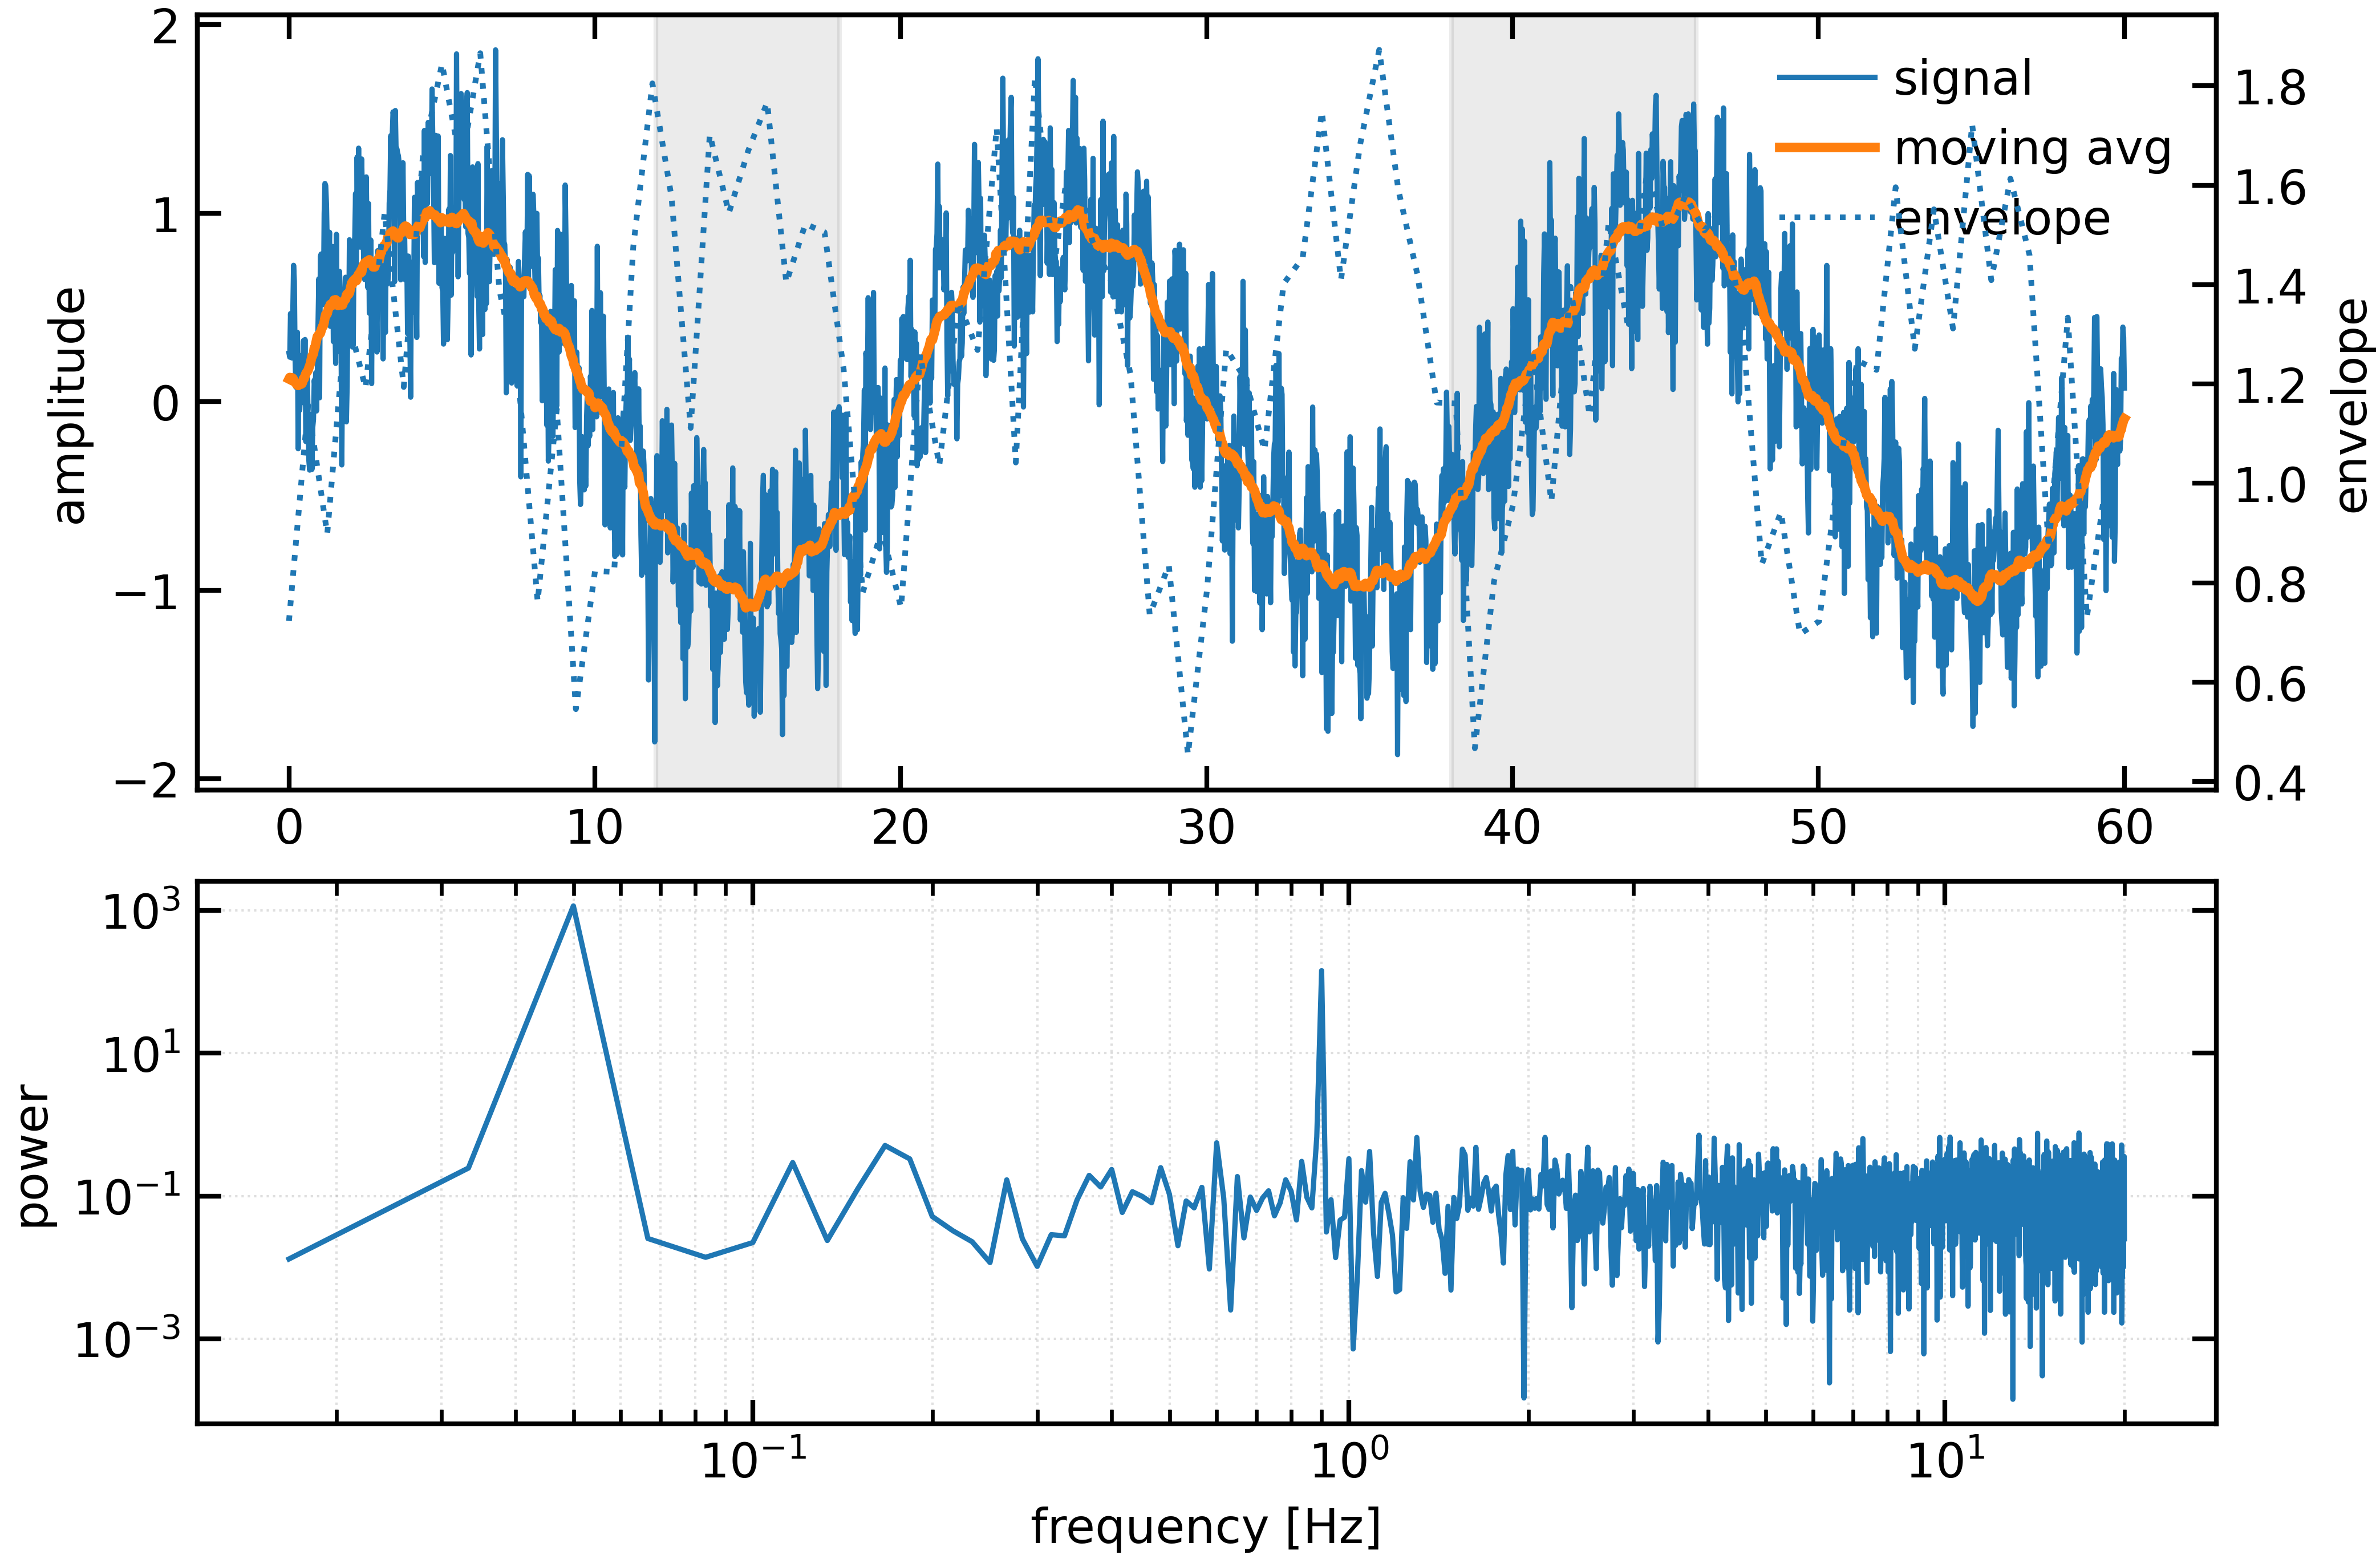

In [3]:
%%mplfreeze timeseries_demo t y mavg evt_a evt_b freq Pxx

with plt.style.context("lusca"):
    fig = plt.figure(figsize=(7.0, 4.6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.0, 1.4])

    ax = fig.add_subplot(gs[0, 0])
    ax2 = ax.twinx()
    axsp = fig.add_subplot(gs[1, 0])

    # main series
    (l_y,) = ax.plot(t, y, lw=1.1, label="signal")
    (l_ma,) = ax.plot(t, mavg, lw=2.0, label="moving avg")

    # envelope proxy (downsampled abs for cleanliness)
    step = 25
    env_t = t[::step]
    env = np.maximum.reduceat(np.abs(y), np.arange(0, y.size, step))
    (l_env,) = ax2.plot(env_t, env, ":", lw=1.2, label="envelope")

    # event shading (no labels)
    ax.axvspan(*evt_a, color="k", alpha=0.08)
    ax.axvspan(*evt_b, color="k", alpha=0.08)

    ax.set_ylabel("amplitude")
    ax2.set_ylabel("envelope")

    # spectrum (log–log, clean grid)
    axsp.loglog(freq[1:], Pxx[1:], lw=1.1)
    axsp.set_xlabel("frequency [Hz]")
    axsp.set_ylabel("power")
    axsp.grid(True, which="both", ls=":", alpha=0.4)

    # single, unobtrusive legend (top-right of upper panel)
    ax.legend(handles=[l_y, l_ma, l_env], loc="upper right", frameon=False)
    plt.show()


In [4]:
# === 2) Scalar field: heatmap + contours + inset zoom (one colorbar) ===
x = np.linspace(-5, 5, 241)
y2 = np.linspace(-4, 4, 193)
X, Y = np.meshgrid(x, y2)
R2 = X**2 + Y**2
Z = np.exp(-0.1 * R2) * np.cos(2.5 * X) * np.sin(1.8 * Y)

# contour levels (sparse to avoid clutter)
levels = np.linspace(Z.min(), Z.max(), 11)

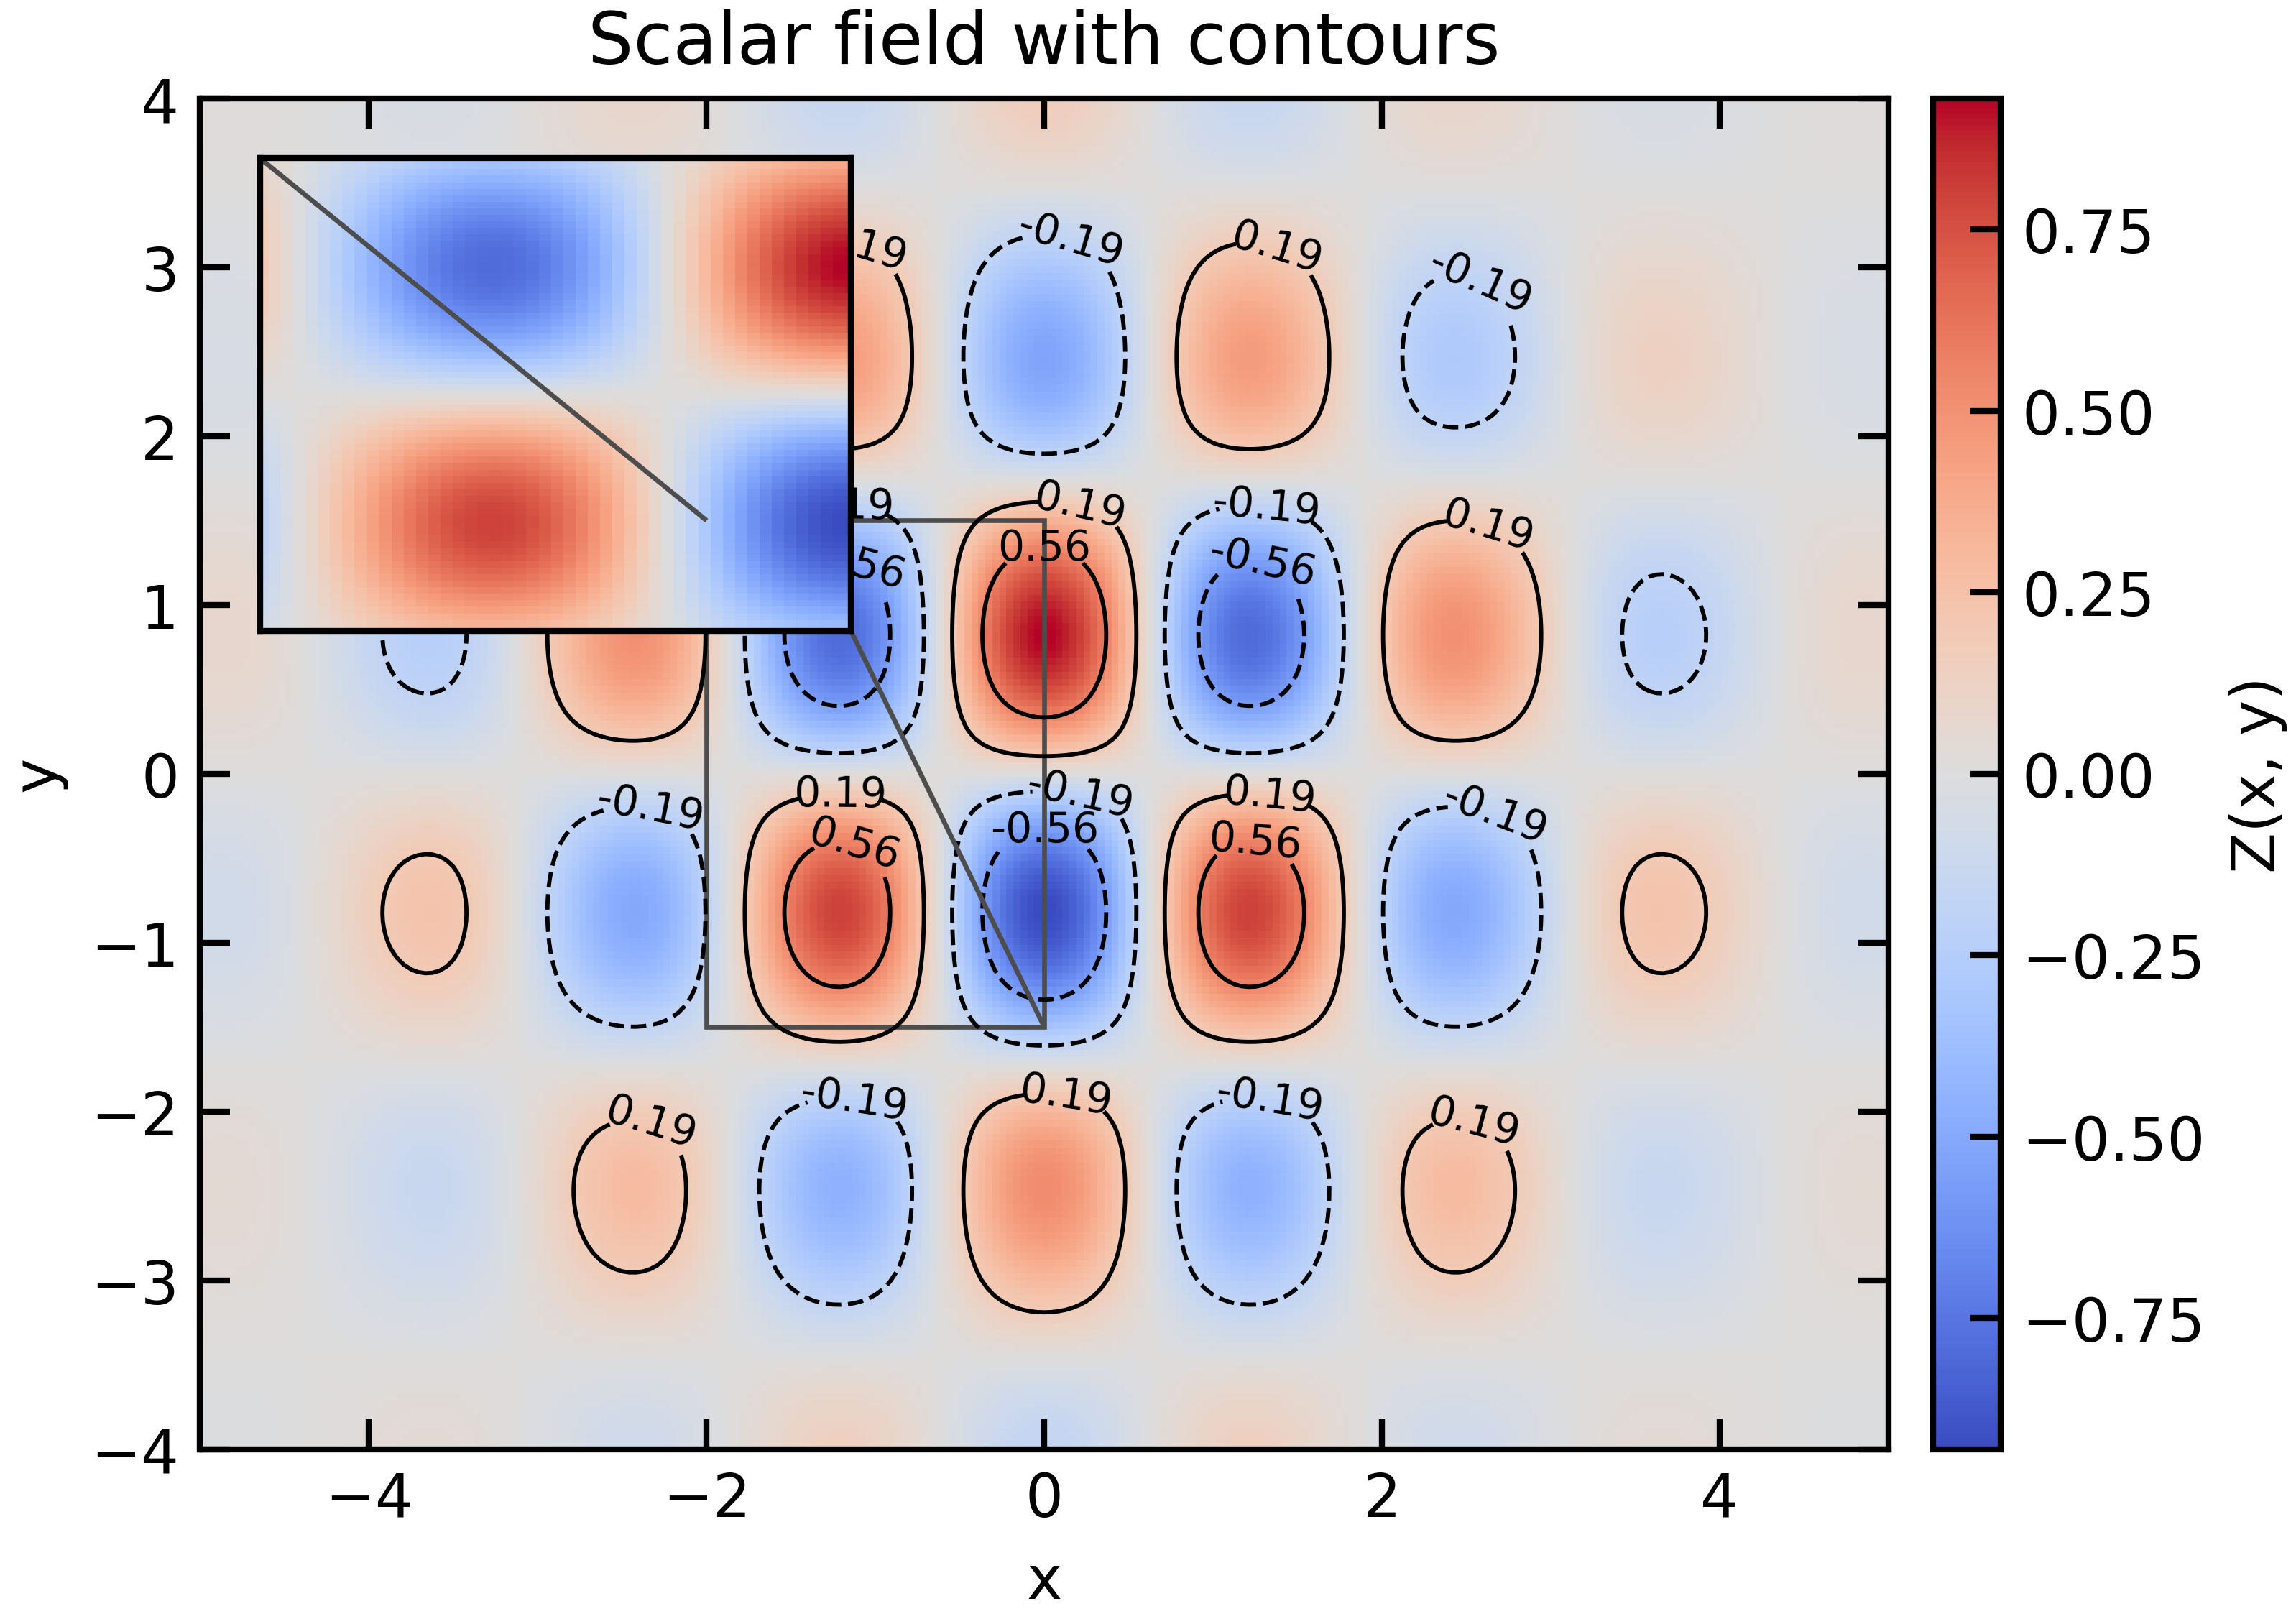

In [5]:
%%mplfreeze field_demo X Y Z levels

with plt.style.context("lusca"):
    fig, ax = plt.subplots(figsize=(6.2, 3.8), constrained_layout=True)

    # diverging around 0 with one colorbar
    from matplotlib.colors import TwoSlopeNorm

    im = ax.imshow(
        Z,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        origin="lower",
        aspect="equal",
        cmap="coolwarm",
        norm=TwoSlopeNorm(vmin=Z.min(), vcenter=0.0, vmax=Z.max()),
    )
    cs = ax.contour(X, Y, Z, levels=levels[::2], colors="k", linewidths=0.7)
    ax.clabel(cs, fmt="%.2f", fontsize=7)

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("Z(x, y)")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Scalar field with contours")

    # minimal inset zoom (tests insets without clutter)
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    iax = inset_axes(ax, width="35%", height="35%", loc="upper left", borderpad=1.0)
    x0, x1, y0, y1 = -2.0, 0.0, -1.5, 1.5
    iax.imshow(
        Z,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        origin="lower",
        aspect="auto",
        cmap="coolwarm",
        norm=im.norm,
    )
    iax.set_xlim(x0, x1)
    iax.set_ylim(y0, y1)
    iax.set_xticks([])
    iax.set_yticks([])
    mark_inset(ax, iax, loc1=2, loc2=4, fc="none", ec="0.3", lw=0.8)

    plt.show()

In [6]:
# === 3) Weighted fit + residuals: two rows, thin colorbar, compact legend ===
x_d = np.linspace(-3, 3, 140)
true = 0.9 * x_d**3 - 1.1 * x_d
sigma = 0.18 + 0.12 * (1 + np.sin(2.3 * x_d))
y_obs = true + rng.normal(0, sigma)

# weighted cubic fit
coeffs = np.polyfit(x_d, y_obs, 3, w=1 / sigma)
y_fit = np.polyval(coeffs, x_d)
resid = y_obs - y_fit

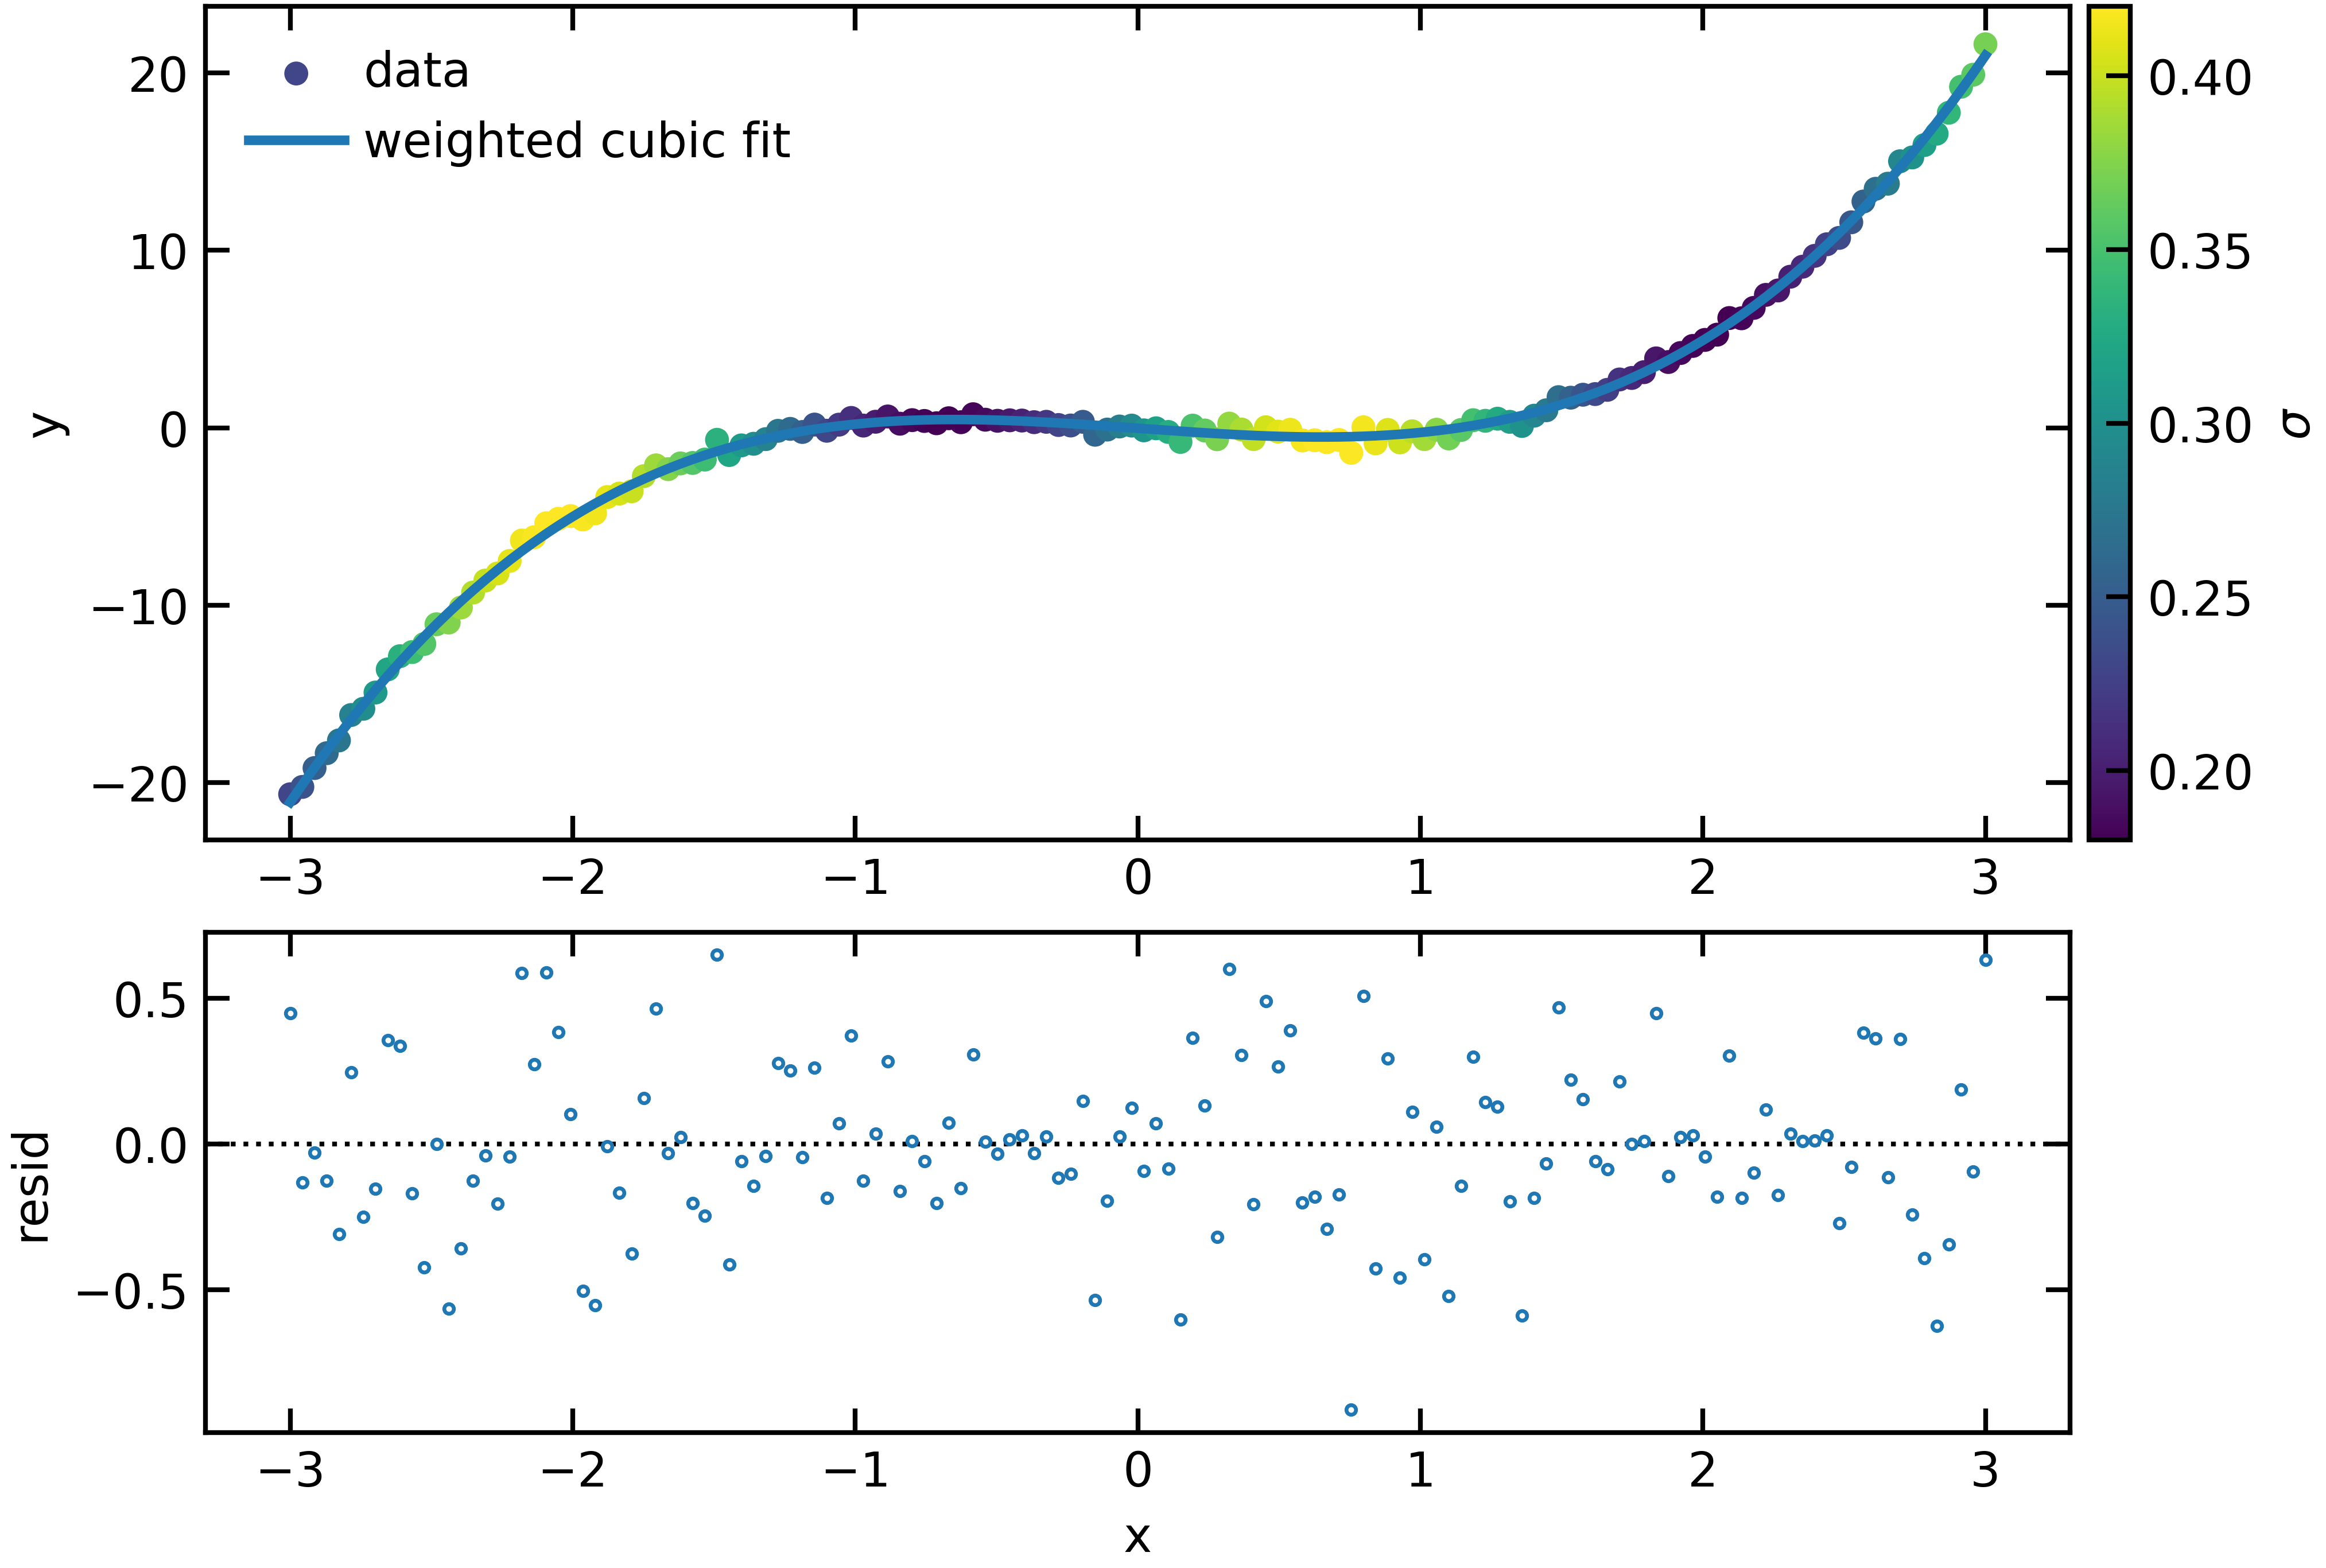

In [7]:
%%mplfreeze fit_demo x_d y_obs sigma y_fit resid coeffs

with plt.style.context("lusca"):
    fig = plt.figure(figsize=(6.8, 4.6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.0, 1.2])

    ax = fig.add_subplot(gs[0, 0])
    axr = fig.add_subplot(gs[1, 0], sharex=ax)

    # data colored by per-point σ + fit
    sc = ax.scatter(x_d, y_obs, c=sigma, s=16, cmap="viridis", label="data")
    (l_fit,) = ax.plot(x_d, y_fit, lw=2.0, label="weighted cubic fit")

    # thin colorbar tucked to the right
    cb = fig.colorbar(sc, ax=ax, pad=0.01, fraction=0.04)
    cb.set_label(r"$\sigma$")

    ax.set_ylabel("y")
    ax.legend(loc="upper left", frameon=False)

    # residuals panel (no extra legend)
    axr.axhline(0, color="k", ls=":", lw=1)
    axr.plot(x_d, resid, ".", ms=4)
    axr.set_xlabel("x")
    axr.set_ylabel("resid")

    plt.show()